This notebook demonstrates the use of Python to explore a dataset containing offensive speech along with other attributes. Learning goals of this notebook - <br>
* Organize the data in Pandas dataframe, a key data structure of Python
* Provide some descriptive statistics about the dataset
* Prepare the comments containing offensive speeches for further texual analysis by removing stopwords, lowercasing, stemming, etc
* Use CountVectorizer module to convert the collection of speeches (or, tweets) into a matrix containing term or word frequencies in each tweet
* Calculate TF-IDF score of each term or word to determine the importance of that term in a specific tweet

Content Warning: The fetched dataset in this notebook contains hateful and harrassing comments which some may find offensive. 

Author: Saklain Zaman


In [ ]:
# Code Block 1
# URL of the dataset as csv file in github repo
url = "https://raw.githubusercontent.com/jmstanto/speechdata/main/Datasets/labeled_data.csv"

In [ ]:
# Code Block 2
import pandas as pd
import requests
import io

In [ ]:
# Code Block 3
# Read the csv file from url into a Pandas dataframe
df = pd.read_csv(url) 
print(df.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In the given code, the dataset is stored in a pandas dataframe, a rectangular data structure. Pandas provide various in-built capabilities for performing analytical tasks.

In [ ]:
# Code Block 4
df.shape  # This dataset has 24783 rows and 7 columns as different attributes

(24783, 7)

The pandas DataFrame has 24783 tweets for offensive speech detection. Other attributes of the comments are also stored in the DataFrame.



In [ ]:
# Code Block 5
tweets = df['tweet'] 
tweets # 24783 tweets 

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [ ]:
# Code Block 6
list(df.columns) # The 7 columns contain the tweets and various attributes of the tweets

['Unnamed: 0',
 'count',
 'hate_speech',
 'offensive_language',
 'neither',
 'class',
 'tweet']

In [ ]:
# Code Block 7
# Some descriptive statistics about the dataset
df.describe(include='all') 


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783
unique,NaN,NaN,NaN,NaN,NaN,NaN,24783
top,NaN,NaN,NaN,NaN,NaN,NaN,!!! RT @mayasolovely: As a woman you shouldn't...
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277,NaN
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089,NaN
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000,NaN
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN


In [ ]:
# Code Block 8
# Count of the elements in a specific column
df['tweet'].count()

24783

In [ ]:
# Code Block 9
# Count of distinct elements in different columns
df[['hate_speech','offensive_language','neither','class']].nunique()

hate_speech            8
offensive_language    10
neither               10
class                  3
dtype: int64

In [ ]:
# Code Block 10
import re

In [ ]:
# Code Block 11
# This method can extract the urls starting with "https:" or "http:"
def extract_urls(tweet):  
  urls = []
  tokens = tweet.split()

  for token in tokens:
    if token.startswith("https:") or token.startswith("http:"):
      urls.append(token)
  return urls

In [ ]:
# Code Block 12
# This method can extract and clean the tokens with special patterns using regular expression
def clean_tweet(tweet):
    # Regular expression for finding mentions
    mention_pattern = re.compile(r'@\w+')
    mentions = mention_pattern.findall(tweet)

    # Regular expression for finding users
    user_pattern = re.compile(r'@\w{1,15}:')
    users = user_pattern.findall(tweet)

    for user in users:
      if user[:-1] in mentions:
        mentions.remove(user[:-1])

    # Regular expression for finding hashtags
    hashtag_pattern = re.compile(r'#\w+')
    hashtags = hashtag_pattern.findall(tweet)

    # Extract urls
    urls = extract_urls(tweet)

    special_tokens = mentions + users + hashtags + urls # Join all found special patterns

    # Remove the special patterns from the tweet
    tweet_tokens = tweet
    for token in special_tokens:
      tweet_tokens = tweet_tokens.replace(token," ")

    return users, mentions, hashtags, urls, tweet_tokens

In [ ]:
# Code Block 13
# Clean all the tweets and store the extracted tokens in the dataframe
def modify_df():
  # Initiate lists for different special tokens
  user_list = []
  usernames_list = []
  hashtags_list = []
  url_list = []
  filtered_tokens = []

  for tweet in df['tweet']:
    user, usernames, hashtags, urls, tokens = clean_tweet(tweet) 
    
    user_list.append(user)
    usernames_list.append(usernames)
    hashtags_list.append(hashtags)
    url_list.append(urls)
    filtered_tokens.append(tokens)

  df['user'] = user_list
  df['mentions'] = usernames_list
  df['hashtags'] = hashtags_list
  df['urls'] = url_list
  df['filtered_tokens'] = filtered_tokens


In [ ]:
# Code Block 14
modify_df()

In [ ]:
# Code Block 15
df # Display the modified dataframe

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,user,mentions,hashtags,urls,filtered_tokens
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,[@mayasolovely:],[],[],[],!!! RT As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,[@mleew17:],[],[],[],!!!!! RT boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,[@80sbaby4life:],[@UrKindOfBrand],[],[],!!!!!!! RT Dawg!!!! RT You ever fuck a bit...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,[@C_G_Anderson:],[@viva_based],[],[],!!!!!!!!! RT she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,[@ShenikaRoberts:],[],[#57361],[],!!!!!!!!!!!!! RT The shit you hear about me ...
...,...,...,...,...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,[@LifeAsKing:],"[@20_Pearls, @corey_emanuel]","[#8220, #8230, #8221]",[],you's a muthaf***in lie & ; right! His TL...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",[],[],[],[],"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,[],[],[],[],young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,[],[],[],[],youu got wild bitches tellin you lies


For further texual analysis of the tweets, the tweets need to be cleaned, and then, converted into a **Document-Term Frequency Matrix**. In this step, from the comments, the stop words are removed, words are converted to lowercase, words are stemmed, and finally, a pandas dataframe will be generated containing term frequencies. <br>

In the dataframe, each row represent a document (or, tweet) and there are columns equal to total number of words in the vocabulary. This is generally a very sparse matrix as most of the words don't appear in a single document but there's a lot of words in the vocabulary.

**CountVectorizer** module from sklearn is used to create a document-term frequency matrix from the tweets. Each integer element in the matrix represent the frequency of the respective word in a specific document.

In [ ]:
# Code Block 16
# Import some important libraries 
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer

In [ ]:
# Code Block 17
# Import the list of stopwords
all_stopwords = text.ENGLISH_STOP_WORDS

# Create a stemmer object 
stemmer = PorterStemmer()

# Helper function for stemming 
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc)) 

In [ ]:
# Code Block 18
# Create countvectorizer object  
# Supports preprocessing (lowercasing, removing stopwords, stemming) on raw data
vectorizer = CountVectorizer(lowercase=True, stop_words=all_stopwords, analyzer=stemmed_words) 

In [ ]:
# Code Block 19
# Create sparse DTM (Document-Term Matrix)
# spDTM = vectorizer.fit_transform(df['tweet'])
spDTM = vectorizer.fit_transform(df['filtered_tokens'])

# Store the DTM in pandas dataframe
spDTM = pd.DataFrame(spDTM.toarray())

# Set the column/feature names as document terms
spDTM.columns = vectorizer.get_feature_names_out()

In [ ]:
# Code Block 20
spDTM # Display the DTM for the collection of comments/tweets

,00,000,0000000000000,003,007,00am,00pm,01,01vjzqnahh,02,...,zstrqbpwpw,zucchini,zuko,zulema,zulu,zuvwccn0iv,zvjroxgndq,zycuodiwkz,zzzquil,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Code Block 21
spDTM.shape # The total vocabulary size should be 14997 and there's 24783 tweets in total

(24783, 14997)

In [ ]:
# Code Block 22
spDTM.info() # Some additional information about the datatype, count and memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Columns: 14997 entries, 00 to zzzzzz
dtypes: int64(14997)
memory usage: 2.8 GB


In [ ]:
# Code Block 23
# Get the list of vocabulary with their frequency from the vectorizer object
vocabulary_ = list(vectorizer.vocabulary_.keys())

In [ ]:
# Code Block 24
# Check the number of tokens in the vocabulary 
print(len(vocabulary_)) 

14997


In [ ]:
# Code Block 25
# Print the list of vocabulary
print(vocabulary_) 

['rt', 'as', 'woman', 'you', 'shouldn', 'complain', 'about', 'clean', 'up', 'your', 'hous', 'amp', 'man', 'should', 'alway', 'take', 'the', 'trash', 'out', 'boy', 'dat', 'cold', 'tyga', 'dwn', 'bad', 'for', 'cuffin', 'hoe', 'in', '1st', 'place', 'dawg', 'ever', 'fuck', 'bitch', 'and', 'she', 'start', 'to', 'cri', 'be', 'confus', 'shit', 'look', 'like', 'tranni', 'hear', 'me', 'might', 'true', 'or', 'it', 'faker', 'than', 'who', 'told', 'ya', 'just', 'blow', 'claim', 'so', 'faith', 'down', 'somebodi', 'but', 'still', 'with', 'can', 'not', 'sit', 'hate', 'on', 'anoth', 'got', 'too', 'much', 'go', 'caus', 'tire', 'of', 'big', 'come', 'us', 'skinni', 'girl', 'get', 'back', 'that', 'hobbi', 'includ', 'fight', 'mariam', 'keek', 'is', 'curv', 'everyon', 'lol', 'walk', 'into', 'convers', 'thi', 'smh', 'murda', 'gang', 'land', 'smoke', 'are', 'loser', 'yea', 'ig', 'onli', 'thing', 'off', 'nigga', 'miss', 'plz', 'whatev', 'do', 'love', 'cut', 'everyday', 'black', 'bottl', 'broke', 'cant', 'tell'

<b> Reducing the Number of Vocabulary/Features </b> <br>
In the document term matrix, we can reduce the vocabulary size by removing the columns for the terms rarely occurring in the collection of documents(tweets).

In [ ]:
# Code Block 26
# Removing the columns for the features(words) which occur less than 20 times across all documents
spDTMtrim = spDTM[spDTM.columns[spDTM.sum()>=20]] 
spDTMtrim


,000,10,100,11,12,13,15,17,18,1st,...,yo,you,young,your,yourself,yr,yu,yung,zebra,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
24779,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
24780,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
24781,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Code Block 27
# A snippet of the term occurrences in different documents. 
# This matrix is sparse
spDTMtrim.iloc[225:235, 360:370]

,duck,dude,dumb,dumbass,dure,dyke,each,ear,earli,earth
225,0,0,0,0,0,0,0,0,0,0
226,0,0,0,0,0,0,0,0,0,0
227,0,0,0,0,0,0,0,0,0,0
228,0,0,0,0,0,0,0,0,0,0
229,0,0,0,0,0,0,0,0,0,0
230,0,0,0,0,0,0,0,0,0,0
231,0,0,0,0,0,0,0,0,0,0
232,0,0,0,0,0,0,0,0,0,0
233,0,0,0,0,0,0,0,0,0,0
234,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Code Block 28
# Print the trimmed list of vocabulary
vocabulary_trimmed = spDTMtrim.columns # Extract the vocabulary from the columns/feature names


In [ ]:
# Code Block 29
# After reducing the rare words, the size of vocabulary
len(vocabulary_trimmed)

1364

In [ ]:
# Code Block 30
print(vocabulary_trimmed[0:20]) # First 20 terms in alphabetical order

Index(['000', '10', '100', '11', '12', '13', '15', '17', '18', '1st', '20',
       '2014', '21', '24', '30', '40', '50', '90', '99', 'abo'],
      dtype='object')


The terms present in the collection of document can be visually displayed as a wordcloud. <br>
The modules - **wordcloud** and **matplotlib** are used to demonstrate this visualization.

In [ ]:
# Code Block 31
# !pip install wordcloud
# !pip install matplotlib

In [ ]:
# Code Block 32
# Import wordcloud and matplotlib module to create and display a wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Code Block 33
# Append all the words in the vocabulary to match the input format of the wordcloud module
vocabulary = ' '.join(vocabulary_trimmed).lower()

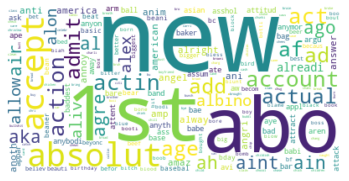

In [ ]:
# Code Block 34
# Create the wordcloud object
wordcloud = WordCloud(stopwords = all_stopwords,
                      collocations=True,
                      background_color='white'
                      ).generate(vocabulary)

# Plot the wordcloud object using matplotlib
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()


We want to understand how relevant a word is in a document or comment, considering the collection of documents. **TF-IDF (Term Frequency - Inverse Document Frequency)** is an approach to measure this. 

TF-IDF is the multiplication of two terms - TF and IDF. <br>
**TF** represents the frequency of a word or term in a document (or, comment). <br>
**IDF** is the logarithm of total number of documents divided by the number of documents containing the specific term plus 1. 

TF-IDF score helps to quantify the relevancy of a term or word in a collection of documents.

L2 normalization can be applied to calculated TF-IDF scores to scale the values. It scales the values in every row in such a way that if all the values in a row are squared and summed, the result will be 1.

Built-in model from sklearn is imported for calculating the TF-IDF scores.

In [ ]:
# Code Block 35
# Import model for TF-IDF calculation from sklearn
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# Code Block 36
# Get TfidfTransformer model with L2 normalization
tfidf_transformer = TfidfTransformer(norm='l2') 

# Use the DTM as input to the TfidfTransformer model
sp_tf_idf = tfidf_transformer.fit_transform(spDTMtrim) 

# Convert the generated tf-idf matrix to pandas dataframe
sp_tf_idf = pd.DataFrame(sp_tf_idf.toarray()) 

# Use the features(words) as the column names of the tf-idf matrix
sp_tf_idf.columns = tfidf_transformer.get_feature_names_out() 

print(sp_tf_idf.shape)

sp_tf_idf.iloc[225:235, 360:370]

(24783, 1364)


,duck,dude,dumb,dumbass,dure,dyke,each,ear,earli,earth
225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Code Block 37
print("Tf-idf matrix using TfidfTransformer:\n")
print(round(sp_tf_idf.iloc[225:235, 360:370],2))

Tf-idf matrix using TfidfTransformer:

     duck  dude  dumb  dumbass  dure  dyke  each  ear  earli  earth
225   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
226   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
227   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
228   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
229   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
230   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
231   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
232   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
233   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0
234   0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0    0.0    0.0


In [ ]:
# Code Block 38
print("Actual word frequency for comparison:\n")
print(spDTMtrim.iloc[225:235, 360:370])

Actual word frequency for comparison:

     duck  dude  dumb  dumbass  dure  dyke  each  ear  earli  earth
225     0     0     0        0     0     0     0    0      0      0
226     0     0     0        0     0     0     0    0      0      0
227     0     0     0        0     0     0     0    0      0      0
228     0     0     0        0     0     0     0    0      0      0
229     0     0     0        0     0     0     0    0      0      0
230     0     0     0        0     0     0     0    0      0      0
231     0     0     0        0     0     0     0    0      0      0
232     0     0     0        0     0     0     0    0      0      0
233     0     0     0        0     0     0     0    0      0      0
234     0     0     0        0     0     0     0    0      0      0
